#### Importing Libraries

In [39]:
import os                              #to interact with the operating system
import numpy as np                     #mathematical computation
import matplotlib.pyplot as plt        #2D plotting
from skimage.transform import resize   #resizing images
from sklearn.utils import shuffle      #for randomizing the order of data before training (prevent bias)
import tqdm                            #create progress bars in graphical user interfaces to track the progress of operations


#### Setting Path and Loading Data

In [40]:
path = r"C:\Users\taman\Downloads\archive"
#creates paths for male and female eye image folders.
female = os.path.join(path, 'femaleeyes')
male = os.path.join(path, 'maleeyes')
#Lists the files in the male and female eye image folders.
maleList = os.listdir(male)
femaleList = os.listdir(female)

#### Initialization and Resizing

In [41]:
#Initialization and Resizing:
X = []                                 #Initialize empty lists to store images and corresponding labels.
Y = []

#Setting image size
IMG_SIZE = (64, 64)

# male eyes
for i in tqdm.tqdm(range(len(maleList))):
    file_path = os.path.join(male, maleList[i])
    img = plt.imread(file_path)         #Reads the image using Matplotlib
    img = resize(img, IMG_SIZE + (3,))  #Resizes the image to the specified size
    X.append(np.array(img))             #appends the image and corresponding label to the lists
    Y.append(0)

# female eyes
for i in tqdm.tqdm(range(len(femaleList))):
    file_path = os.path.join(female, femaleList[i])
    img = plt.imread(file_path)
    img = resize(img, IMG_SIZE + (3,))
    X.append(np.array(img))
    Y.append(1)

100%|█████████████████████████████████████████████████████████████████████████████| 5202/5202 [00:05<00:00, 882.78it/s]


#### Conversion and Shuffling the Data

In [42]:
#Converts the lists into NumPy arrays
X = np.array(X)  
Y = np.array(Y)

# Shuffle the data
seed = 42  
X, Y = shuffle(X, Y, random_state=seed)


#### Plot some images

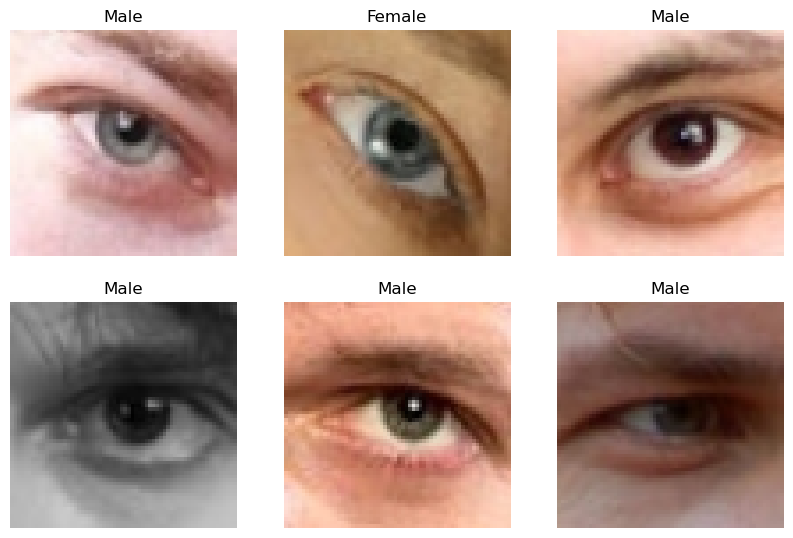

In [43]:
import random as rn          #generate random indices for selecting images
labels=['Male','Female']
plt.figure(figsize=(10,10))
for i in range(6):
    n=rn.randint(0,len(X))   # Randomly select an index 'n' from our dataset
    plt.subplot(3,3,i+1)     # Create a subplot in a 3x3 grid
    plt.imshow(X[n])         # Display the image at index 'n'
    plt.title(labels[Y[n]])  # Set the title of the subplot with the corresponding label
    plt.axis('off')          # Turn off axis labels

#### Split the data into train and test

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=seed)  # 0.2 means we are using 20% data for test
# change the labels to one hot encoding
from keras.utils import to_categorical
Y_train_to_categorical=to_categorical(Y_train)
Y_test_to_categorical=to_categorical(Y_test)

#### Load the vgg16 model

In [45]:
#include_top=False means don't want to include the fully connected layers instead we add our own custom layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))  #images dimensions 64x64 pixels,RGB channel
#Freezes the weights of the pre-trained VGG16 model
base_model.trainable = False

#### Building a neural network model

In [46]:
# add some layers
model = models.Sequential()                       #Initializes a new Sequential model
model.add(base_model)                             #Adds a pre-existing model to the current model
model.add(layers.Flatten())                       #responsible for flattening the input into a 1-D array
model.add(layers.Dense(1024, activation='selu'))
model.add(layers.Dense(512, activation='selu'))
model.add(layers.Dense(2, activation='softmax')) #output layer with 2 units (assuming it's a binary classification task) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 17338690 (66.14 MB)
Trainable params: 2624002 (10.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#### Compile the model

In [47]:
# 'adam'popular optimization algorithm,For multi-class classification use categorical_crossentropy,Metrics uses to evaluate the performance of the model during training
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [48]:
# train the model
history=model.fit(X_train,Y_train_to_categorical,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
58/58 [==============================] - 58s 995ms/step - loss: 1.4612 - accuracy: 0.6834 - val_loss: 0.4126 - val_accuracy: 0.8075
Epoch 2/10
58/58 [==============================] - 61s 1s/step - loss: 0.3447 - accuracy: 0.8515 - val_loss: 0.3535 - val_accuracy: 0.8449
Epoch 3/10
58/58 [==============================] - 62s 1s/step - loss: 0.3035 - accuracy: 0.8682 - val_loss: 0.3365 - val_accuracy: 0.8601
Epoch 4/10
58/58 [==============================] - 62s 1s/step - loss: 0.2617 - accuracy: 0.8925 - val_loss: 0.2708 - val_accuracy: 0.8861
Epoch 5/10
58/58 [==============================] - 61s 1s/step - loss: 0.2608 - accuracy: 0.8900 - val_loss: 0.2659 - val_accuracy: 0.8921
Epoch 6/10
58/58 [==============================] - 62s 1s/step - loss: 0.2439 - accuracy: 0.8976 - val_loss: 0.3860 - val_accuracy: 0.8449
Epoch 7/10
58/58 [==============================] - 64s 1s/step - loss: 0.2050 - accuracy: 0.9178 - val_loss: 0.2593 - val_accuracy: 0.9002
Epoch 8/10
58/58 

#### Plot the accuracy and loss

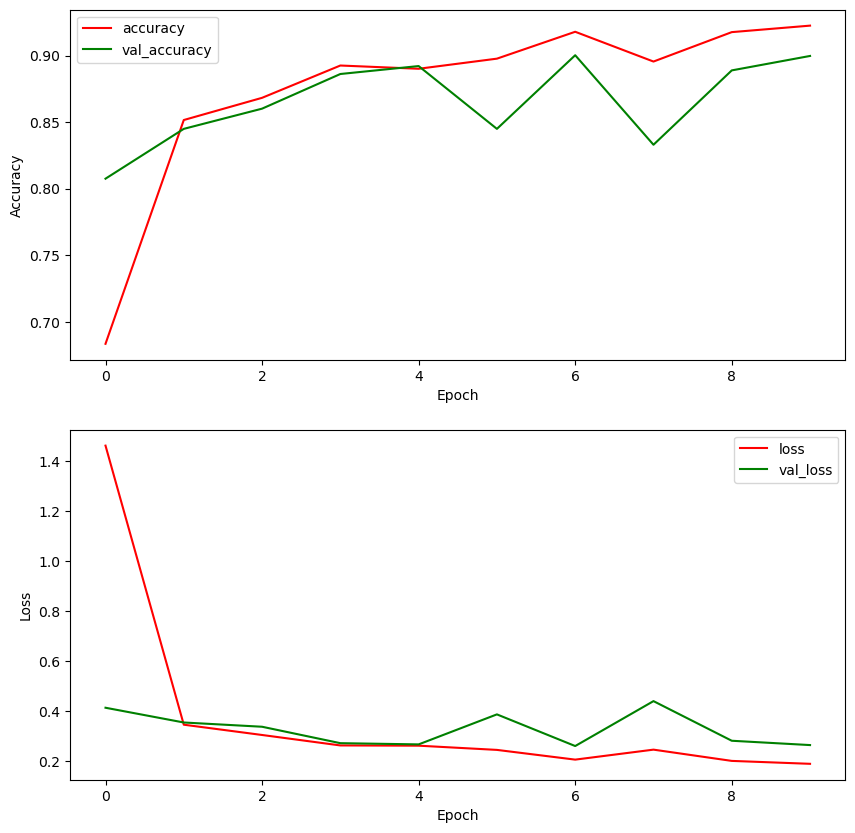

In [49]:
plt.figure(figsize=(10,10))

# Subplot for Accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'],label='accuracy',color="red")
plt.plot(history.history['val_accuracy'],label='val_accuracy',color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for Loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'],label='loss',color="red")
plt.plot(history.history['val_loss'],label='val_loss',color="green")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

#### Evaluate the model

In [50]:
loss,acc=model.evaluate(X_test,Y_test_to_categorical)
print('Loss : ',loss)
print('Accuracy : ',acc)

73/73 [==============================] - 13s 184ms/step - loss: 0.2743 - accuracy: 0.8820
Loss :  0.27432721853256226
Accuracy :  0.881995677947998


73/73 [==============================] - 14s 184ms/step


Text(95.72222222222221, 0.5, 'Truth')

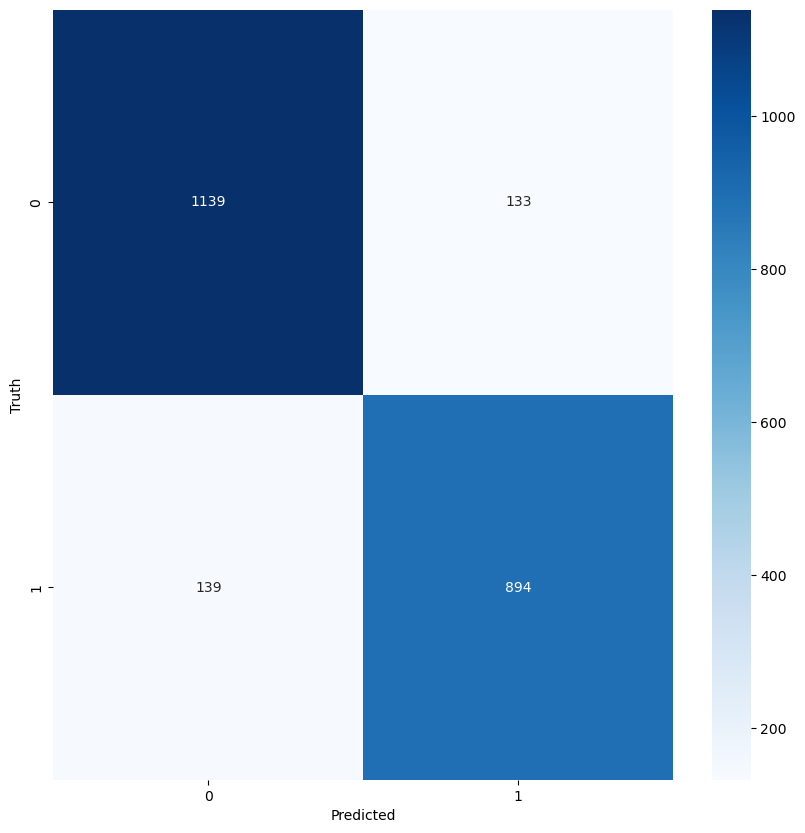

In [51]:
# predict the model
Y_pred=model.predict(X_test)
Y_pred=np.argmax(Y_pred,axis=1)
Y_test=np.argmax(Y_test_to_categorical,axis=1)

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,Y_pred)
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Truth')